GPU aniqlandi va sozlandi: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🧠 TensorFlow strategiyasi: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7c1d5dd55090>
Biz NNni tayyorlaymiz: MLP-1 (128→64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Biz NNni tayyorlaymiz: MLP-2 (256→128)
Biz NNni tayyorlaymiz: MLP-3 (512→256→128)
Biz NNni tayyorlaymiz: WideNet (1024→512)
Biz NNni tayyorlaymiz: ShallowNet (64)
Biz NNni tayyorlaymiz: RegularizedNet (512→256)
Biz klassik modelni o'rgatamiz: RandomForest
Biz klassik modelni o'rgatamiz: KNN
Biz klassik modelni o'rgatamiz: XGBoost

 Eng yaxshi neyron tarmoq: MLP-2 (256→128) (val_accuracy = 0.0942)


<ipython-input-3-8735416ef826>:163: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


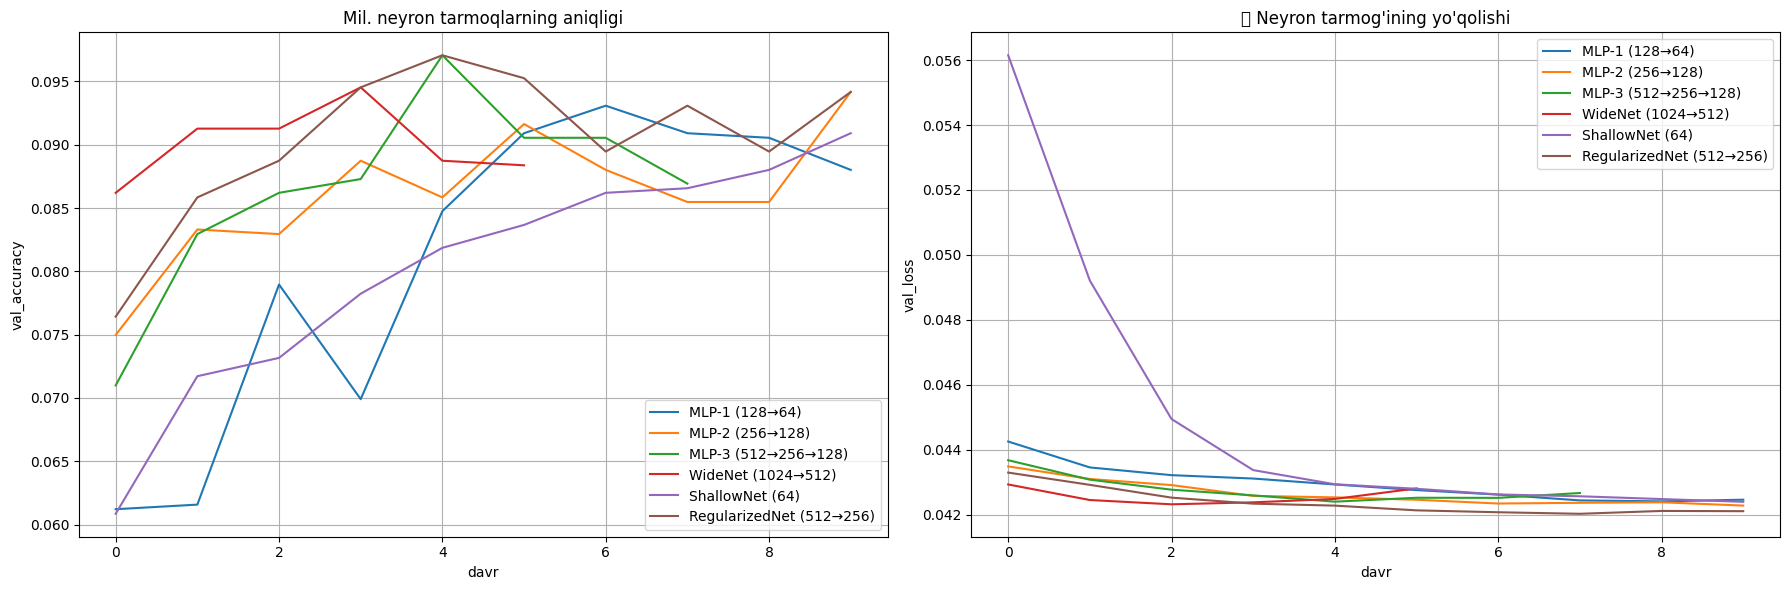

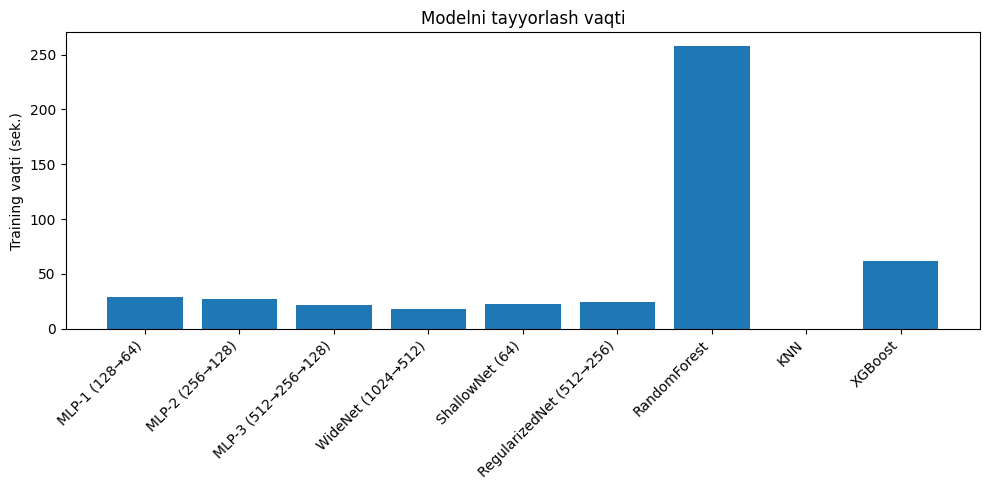


Sotib olingan: ['mineral water', 'eggs']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Biz tavsiya qilamiz: ['chocolate', 'french fries', 'milk']

Eng yaxshi model: MLP-2 (256→128)

 Klassik modellarning aniqligi:
    • RandomForest: 0.0062
    • KNN: 0.0034
    • XGBoost: 0.0107


In [ ]:
# Kerakli kutubxonalarni import qilish va GPU-ni sozlash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb

import joblib

# GPU mavjudligini tekshirish va xotira o‘sishini yoqish
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU aniqlandi va sozlandi:", gpus)
    except RuntimeError as e:
        print("GPU xotirasini sozlashda xatolik:", e)
else:
    print("GPU topilmadi. CPU ishlatiladi.")

# Ko'p GPU bo'lsa, MirroredStrategy yordamida avtomatik tarqatish
strategy = tf.distribute.MirroredStrategy()
print("🧠 TensorFlow strategiyasi:", strategy)


#=== 1. Ma'lumotlarni yuklash va tayyorlash ===
df = pd.read_csv("/content/store_data.csv", header=None)
transactions = df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

mlb = MultiLabelBinarizer()
X_encoded = mlb.fit_transform(transactions)

X_input, y_output = [], []
for t in transactions:
    if len(t) < 2:
        continue
    for i in range(len(t)):
        inp = t[:i] + t[i+1:]
        out = t[i]
        X_input.append(mlb.transform([inp])[0])
        y_output.append(mlb.transform([[out]])[0])
X_input = np.array(X_input)
y_output = np.array(y_output)

# Klassik modellar uchun ajratish
X_train, X_test, y_train, y_test = train_test_split(
    X_input, y_output, test_size=0.2, random_state=42
)


# === 2. Neyron tarmoq konfiguratsiyasi ===
nn_configs = [
    ("MLP-1 (128→64)",           [128, 64],           0.3),
    ("MLP-2 (256→128)",          [256, 128],          0.3),
    ("MLP-3 (512→256→128)",      [512, 256, 128],     0.3),
    ("WideNet (1024→512)",       [1024, 512],         0.3),
    ("ShallowNet (64)",          [64],                0.3),
    ("RegularizedNet (512→256)", [512, 256],          0.5),
]

histories   = []
nn_models   = []
nn_val_acc  = []
times       = []
model_names = []


# === 3. GPU va vaqtni o'lchash bilan neyron tarmoqlarni o'rgatish ===
with strategy.scope():
    for name, layers, drop_rate in nn_configs:
        print(f"Biz NNni tayyorlaymiz: {name}")
        model_names.append(name)
        t0 = time.time()

        # Tarmoq qurilishi
        model = Sequential()
        model.add(Dense(layers[0], activation='relu', input_shape=(X_input.shape[1],)))
        model.add(Dropout(drop_rate))
        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(drop_rate))
        model.add(Dense(X_input.shape[1], activation='sigmoid'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            X_input, y_output,
            epochs=10,
            batch_size=64,
            validation_split=0.1,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
            verbose=0
        )

        t1 = time.time()
        times.append(t1 - t0)
        histories.append(history)
        nn_models.append(model)
        nn_val_acc.append(history.history['val_accuracy'][-1])


#=== 4. Klassik modellarni o'rgatish ===
classic_models = [
    ("RandomForest", MultiOutputClassifier(RandomForestClassifier(n_estimators=100))),
    ("KNN",          MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))),
    ("XGBoost",      MultiOutputClassifier(xgb.XGBClassifier(eval_metric='logloss')))
]

classic_acc = []
for name, clf in classic_models:
    print(f"Biz klassik modelni o'rgatamiz: {name}")
    model_names.append(name)
    t0 = time.time()
    clf.fit(X_train, y_train)
    t1 = time.time()
    times.append(t1 - t0)

    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    classic_acc.append(acc)
    # === 5. Eng yaxshi neyrotarmoqni tanlash ===
best_idx   = np.argmax(nn_val_acc)
best_nn    = nn_configs[best_idx][0]
best_model = nn_models[best_idx]
print(f"\n Eng yaxshi neyron tarmoq: {best_nn} (val_accuracy = {nn_val_acc[best_idx]:.4f})")


# === 6. NN uchun aniqlik va yo'qotish grafiklari ===
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for i, hist in enumerate(histories):
    axs[0].plot(hist.history['val_accuracy'], label=nn_configs[i][0])
axs[0].set_title("Mil. neyron tarmoqlarning aniqligi")
axs[0].set_xlabel("davr")
axs[0].set_ylabel("val_accuracy")
axs[0].legend()
axs[0].grid(True)

for i, hist in enumerate(histories):
    axs[1].plot(hist.history['val_loss'], label=nn_configs[i][0])
axs[1].set_title("📉 Neyron tarmog'ining yo'qolishi")
axs[1].set_xlabel("davr")
axs[1].set_ylabel("val_loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# === 7. Barcha modellar uchun train vaqtining histogrammasi ===
plt.figure(figsize=(10, 5))
plt.bar(model_names, times)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Training vaqti (sek.)")
plt.title("Modelni tayyorlash vaqti")
plt.tight_layout()
plt.show()


# === 8. Eng yaxshi NN ga asoslangan tavsiya funksiyasi ===
def recommend(products, top_n=3):
    vec = mlb.transform([products])[0].reshape(1, -1)
    pred = best_model.predict(vec)[0]
    idxs = pred.argsort()[-top_n:][::-1]
    return [mlb.classes_[i] for i in idxs if mlb.classes_[i] not in products]


# === 9. “Eng yaxshi model” ishi va xulosasi namunasi ===
input_products = ['mineral water', 'eggs']
print(f"\nSotib olingan: {input_products}")
print("Biz tavsiya qilamiz:", recommend(input_products))
print(f"\nEng yaxshi model: {best_nn}")


# === 10. Klassik modellarning aniqligini solishtirish ===
print("\n Klassik modellarning aniqligi:")
for (name, _), acc in zip(classic_models, classic_acc):
    print(f"    • {name}: {acc:.4f}")

In [ ]:
input_products = ['white wine', 'pasta','tomato juice', 'escalope']
print(f"\nSotib olingan: {input_products}")
print("Biz tavsiya qilamiz:", recommend(input_products))
print(f"\nEng yaxshi model: {best_nn}")


Sotib olingan: ['white wine', 'pasta', 'tomato juice', 'escalope']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Biz tavsiya qilamiz: ['french fries', 'mineral water', 'green tea']

Eng yaxshi model: MLP-2 (256→128)
